В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet


Area under ROC score on Train dataset: 0.88%


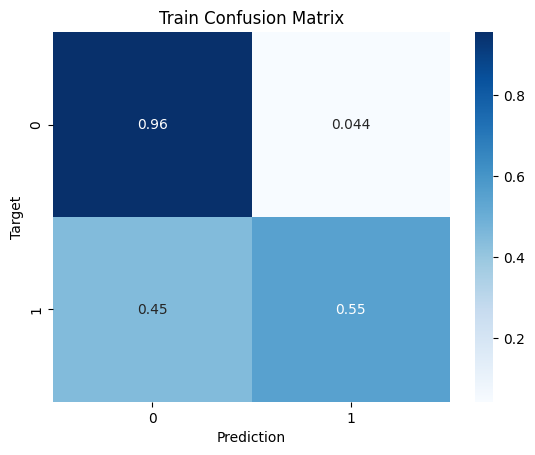

Area under ROC score on Validation dataset: 0.88%


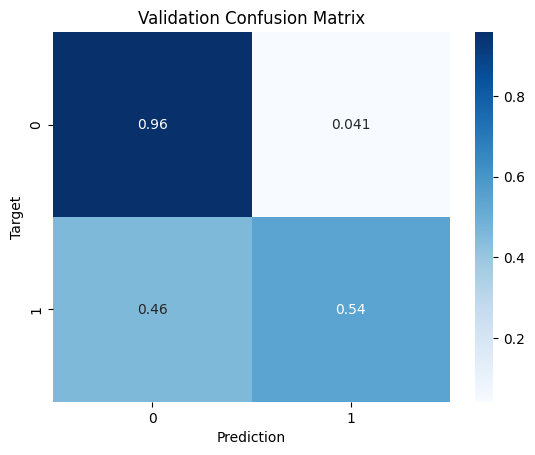

['../../models/bank_customer_churn/log_reg_pipeline.joblib']

In [3]:
train_path = '../../../data/bank-customer-churn-prediction-dlu/train.csv'
test_path = '../../../data/bank-customer-churn-prediction-dlu/test.csv'

raw_df = pd.read_csv(train_path, index_col= 'id')

train_df, val_df = train_test_split(raw_df, random_state=42, train_size=0.2, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = raw_df.columns[1:-1].tolist()
target_col = raw_df.columns[-1]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))

])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, ['Geography', 'Gender'])
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    prob = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, _ = roc_curve(targets, prob, pos_label=1.)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds,  normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

def predict_with_threshold(model_pipeline, inputs, targets, threshold=0.5, name=''):
    
    prob = model_pipeline.predict_proba(inputs)[:, 1]
    # preds = (prob[:, 1] >= threshold).astype(int)
    classify = lambda x: 0 if x < threshold else 1
    preds = np.array([classify(p) for p in prob])

    fpr, tpr, _ = roc_curve(targets, prob, pos_label=1.)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds,  normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# train_preds = predict_with_threshold( model_pipeline, train_inputs, train_targets, threshold=0.3, name='Train')
# val_preds = predict_with_threshold(model_pipeline, val_inputs, val_targets, threshold=0.3, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, '../../models/bank_customer_churn/log_reg_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.93%


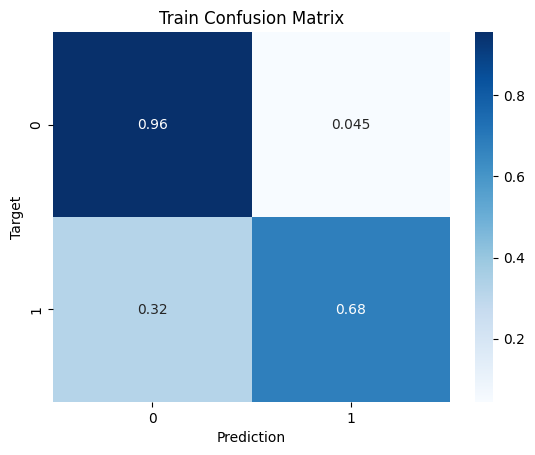

Area under ROC score on Validation dataset: 0.93%


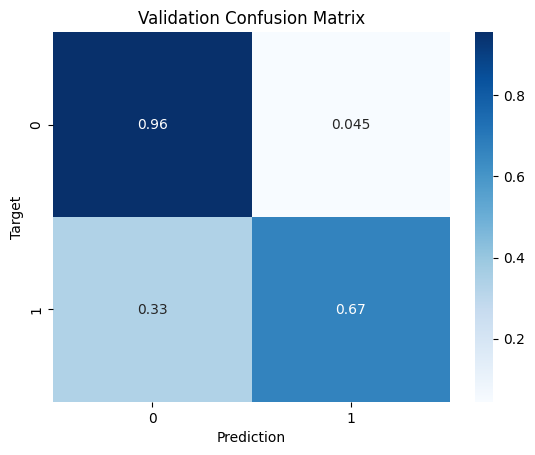

['../../models/bank_customer_churn/log_reg_poly_features_d2_pipeline.joblib']

In [4]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    # ('scaler', MinMaxScaler()),

    ('poly_features', PolynomialFeatures(degree=2))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, ['Geography', 'Gender'])
        # ('cat', categorical_transformer, categorical_cols)

    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
poly_features_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
    # ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))

])

# Тренуємо пайплайн
poly_features_model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(poly_features_model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(poly_features_model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(poly_features_model_pipeline, '../../models/bank_customer_churn/log_reg_poly_features_d2_pipeline.joblib')


Отримана модель має однаково високі значення метрик якості як на тренувальних, так і на валідаційних даних, отже вона добре генералізує та в ній не спостерігається overfit чи underfit. 

In [6]:
test_raw_df = pd.read_csv(test_path, index_col='id')

test_prob = poly_features_model_pipeline.predict_proba(test_raw_df)[:,1]

sample_submission_dir = '../../../data/bank-customer-churn-prediction-dlu/sample_submission.csv'
submission_log_reg = pd.read_csv(sample_submission_dir, index_col=0)
submission_log_reg['Exited'] = test_prob

submission_log_reg.to_csv('../../../data/bank-customer-churn-prediction-dlu/submissions/submission_log_reg_poly_features_d2.csv')

In [198]:
submission_log_reg.head()

,Exited
id,
15000,0.067278
15001,0.015294
15002,0.069437
15003,0.462968
15004,0.025228


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.97%


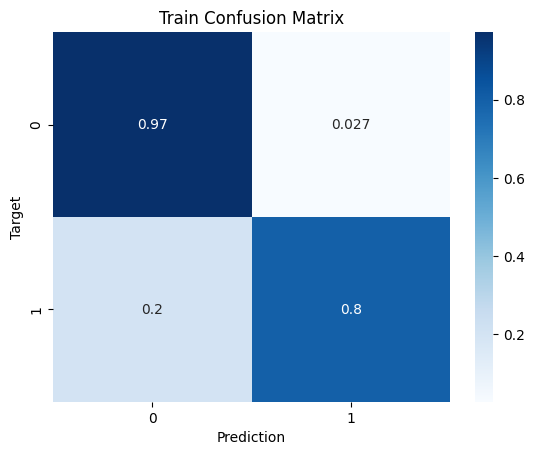

Area under ROC score on Validation dataset: 0.87%


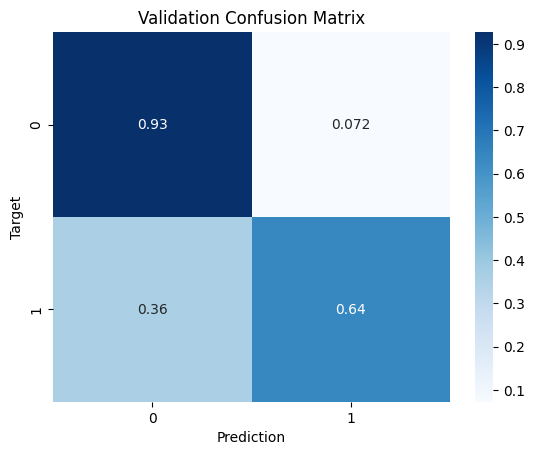

['../../models/bank_customer_churn/log_reg_poly_features_d4_pipeline.joblib']

In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, ['Geography', 'Gender'])

    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
poly_features4_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
poly_features4_model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(poly_features4_model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(poly_features4_model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(poly_features4_model_pipeline, '../../models/bank_customer_churn/log_reg_poly_features_d4_pipeline.joblib')


Отримана модель погано генералізує, так як її точність значно вища на тренувальних даних ніж на валідаційних, отже в ній спостерігається overfit і цю модель не слід використовувати в подальшому для розв'язання задачі

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [8]:
data_dir = '../../../data/'

reg_df = pd.read_csv(data_dir + 'regression_data.csv')

reg_train, reg_test = train_test_split(reg_df, test_size=0.2, random_state=247)


reg_input_cols = reg_df.columns[:-1].tolist()
reg_target_col = reg_df.columns[-1]

reg_train_inputs, reg_train_targets = reg_train[reg_input_cols], reg_train[reg_target_col]
reg_test_inputs, reg_test_targets = reg_test[reg_input_cols], reg_test[reg_target_col]

reg_numeric_cols = reg_train_inputs.select_dtypes(exclude='object').columns.tolist()
reg_categorical_cols = reg_train_inputs.select_dtypes('object').columns.tolist()

reg_df.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482


In [10]:
reg_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1 to 127
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  103 non-null    float64
 1   feature_2  103 non-null    float64
 2   feature_3  103 non-null    float64
 3   feature_4  103 non-null    float64
 4   feature_5  103 non-null    float64
 5   target     103 non-null    float64
dtypes: float64(6)
memory usage: 5.6 KB


In [75]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=5))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, reg_numeric_cols),
    ])

reg_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

reg_model_pipeline.fit(reg_train_inputs, reg_train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly_features',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

In [76]:
reg_train_preds = reg_model_pipeline.predict(reg_train_inputs)
reg_test_preds = reg_model_pipeline.predict(reg_test_inputs)

reg_train_rmse = root_mean_squared_error(reg_train_preds, reg_train_targets)
reg_test_rmse = root_mean_squared_error(reg_test_preds, reg_test_targets)

reg_train_rmse, reg_test_rmse


(2.4864692928307224e-13, 17.868822398873956)

Значення RMSE у отриманої моделі на тренуванальних даних значно нижче, ніж на валідаційних, отже для цієї моделі спостерігається оверфіт і вона погано генералізує

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [77]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    # ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=20))
    # ('poly_features', PolynomialFeatures(degree=5))

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, reg_numeric_cols),
    ])

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Ridge(alpha=0.5))
])

ridge_pipeline.fit(reg_train_inputs, reg_train_targets)

reg_train_preds = ridge_pipeline.predict(reg_train_inputs)
reg_test_preds = ridge_pipeline.predict(reg_test_inputs)

reg_train_rmse = root_mean_squared_error(reg_train_preds, reg_train_targets)
reg_test_rmse = root_mean_squared_error(reg_test_preds, reg_test_targets)

print(f'Train: {reg_train_rmse}, \nTest: {reg_test_rmse}')

Train: 4.398020652156805, 
Test: 4.403833386672788


In [78]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Lasso(alpha=0.3))
])

lasso_pipeline.fit(reg_train_inputs, reg_train_targets)

reg_train_preds = lasso_pipeline.predict(reg_train_inputs)
reg_test_preds = lasso_pipeline.predict(reg_test_inputs)

reg_train_rmse = root_mean_squared_error(reg_train_preds, reg_train_targets)
reg_test_rmse = root_mean_squared_error(reg_test_preds, reg_test_targets)

print(f'Train: {reg_train_rmse}, \nTest: {reg_test_rmse}')


Train: 1.7604006265938767, 
Test: 1.2970981060717195


In [79]:
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ElasticNet(l1_ratio=0.5))
])

elastic_net_pipeline.fit(reg_train_inputs, reg_train_targets)

reg_train_preds = elastic_net_pipeline.predict(reg_train_inputs)
reg_test_preds = elastic_net_pipeline.predict(reg_test_inputs)

reg_train_rmse = root_mean_squared_error(reg_train_preds, reg_train_targets)
reg_test_rmse = root_mean_squared_error(reg_test_preds, reg_test_targets)

print(f'Train: {reg_train_rmse}, \nTest: {reg_test_rmse}')

Train: 30.955423310485102, 
Test: 24.197384243865955


In [63]:
len(lasso_pipeline.named_steps['preprocessor'].get_feature_names_out())

53130

Найкращій резульата з найменшою похибкою і найбільш схожими результатами на тренувальних і валідаціцйних даних дала модель `Lasso`. Це може бути пов'язано з тим що одним з ефектів цієї моделі є зведення дефких коефіцієнтів до 0. 

Тренуванльні дані мають всього 103 записи, а після додавання поліномміальних ознак до 20 степені модель має 53130 ознаки, що перевищує кількість тренувальних прикладів. Тому використовуючи модель `Lasso` ми відбираємо тільки найважливіші ознаки, що значно покращує резільтати навчання.